**Data Exploration**

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns

In [45]:
path = '/content/sample_data/face-emo.csv'

data = pd.read_csv(path)

**Data Preprocessing**

In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
#normalizing pixel data of our data frame
#each pixel entry in the data frame is of type string, so first we must convert them into a list of arrays
#function to convert string into array of numbers
def string_to_array(numbers_string):
    number_strings = numbers_string.split()
    numbers_array = np.array([float(number) for number in number_strings])
    return numbers_array

# Apply the function to the DataFrame column
data['pixels'] = data['pixels'].apply(string_to_array)


#drop the unnecessary columns (label column and column with string data)
norm_data = data.drop(columns =['emotion', 'Usage'])
#y_data = data.emotion


#print(norm_data)

scaler = MinMaxScaler()

#since minmax scalar only works on one value, we must iterate over the array in each row of number in the data frame
for i, row in norm_data.iterrows():
    scaled_array = scaler.fit_transform(np.array(row['pixels']).reshape(-1, 1))
    norm_data.loc[i, 'pixels'] = scaled_array.flatten()

#print(norm_data)

**Model Building**

In [48]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

Splitting data into training and testing sets

In [49]:
ratio = int(0.9 * len(data))

norm_data = np.stack(norm_data['pixels'].values)
print(norm_data.shape)

#first using PCA for data compression (maybe for better clustering by reducing noise?):
variance = 0.98

pca = PCA(variance)

pca.fit(norm_data)
print(pca.n_components_)

compressed_data = pca.transform(norm_data)
print(compressed_data.shape)

training_set, testing_set = train_test_split(compressed_data, test_size=0.1, random_state = 42)

# training_set = norm_data[:ratio]
# testing_set = norm_data[ratio:]

# print(training_set.shape)

#print(len(training_set))
#print(len(testing_set))

#print((training_set))
#print((testing_set))



(3829, 2304)
523
(3829, 523)


This function check the silhouette score for different values assigned to clusters

In [50]:
def apply_silhouette(X, min_clusters, max_clusters):
  scores = []

  for n_clust in range(min_clusters, max_clusters + 1):
      kmeans = KMeans(n_clusters=n_clust, random_state=42)
      labels = kmeans.fit_predict(X)

      #print(kmeans.inertia_)

      score = silhouette_score(X, labels)
      scores.append(score)
  return scores

Checking the silhouette score using K means with the SVD approach

In [51]:
#checking silhouette score using SVD method
n_components = 2

svd = TruncatedSVD(n_components = n_components)

train_svd = svd.fit_transform(training_set)
#test_svd = svd.fit_transform(testing_set)

kmeans_svd = KMeans(n_clusters=7, random_state=42).fit(train_svd)

train_cluster_labels_svd = kmeans_svd.labels_

#test_cluster_labels_svd = kmeans_svd.predict(test_svd)

score_svd = silhouette_score(train_svd, train_cluster_labels_svd)
#score_svd = silhouette_score(test_svd, test_cluster_labels_svd)

print("Silhouette score using SVD: ", score_svd)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score using SVD:  0.33615025554614064


Checking the silhouette score using K means with the PCA approach

In [52]:
#checking silhouette score using PCA method



n_components = 2
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(training_set)
test_pca = pca.fit_transform(testing_set)

kmeans_pca = KMeans(n_clusters=7, random_state=42).fit(train_pca)

train_cluster_labels_pca = kmeans_pca.labels_

test_cluster_labels_pca = kmeans_pca.predict(test_pca)



score_pca = silhouette_score(train_pca, train_cluster_labels_pca)

print("Silhouette score using PCA: ", score_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score using PCA:  0.33614996536210884


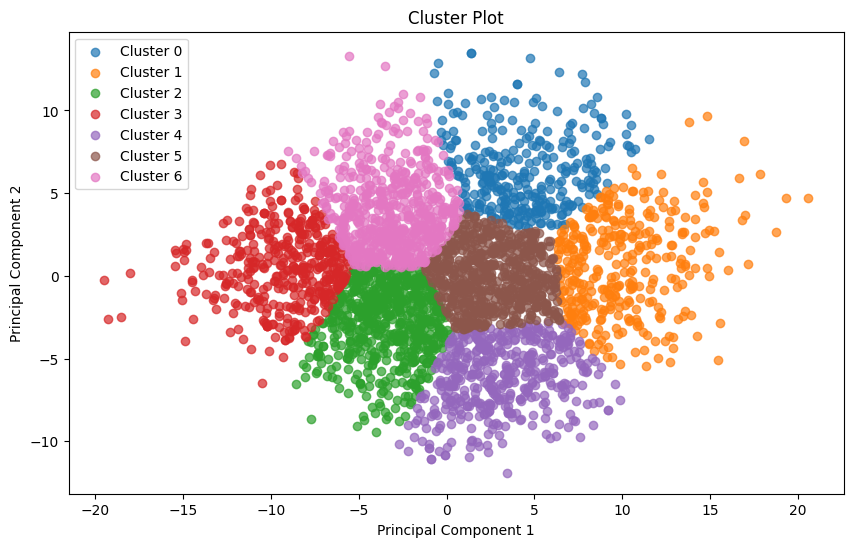

In [53]:
plt.figure(figsize=(10, 6))
for cluster_id in range(max(kmeans_pca.labels_) + 1):
    plt.scatter(
        train_pca[kmeans_pca.labels_ == cluster_id, 0],
        train_pca[kmeans_pca.labels_ == cluster_id, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.7
    )

plt.title('Cluster Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [54]:
''' function -> Use cross validation and check the model score '''
from sklearn.model_selection import cross_val_score, KFold
def apply_cross_validation(kmeans, X):
  k_fold = KFold(n_splits=10, shuffle=True, random_state=21)

  scores = []

  count = 1


  for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]

    kmeans.fit(X_train)

    score = silhouette_score(X_train, kmeans.labels_)

    print("Iteration %d -> score = %.2f" % (count, score))

    scores.append(score)

    count += 1


  print("\nAverage Report: ")
  print("Silhouette avg: %.2f" % (np.mean(scores)))

Testing silhouette score in cross validation

In [55]:
''' function -> Make a function for finding the right number of n_component and n_clusters arugument '''
def optimized_params(comp_range, cluster_range, data):
  param = {'n_components': 0, 'n_clusters': 0, 'score': -100, 'data_pca': None, 'training_set': None}
  model = None
  kmeans_args = {
       "init": "random",
       "n_init": 10,
       "max_iter": 300,
       "random_state": 42,
  }

  training_set, testing_set = train_test_split(data, test_size=0.1, random_state = 42)
  max_score = -100

  for n_components in range(comp_range[0], comp_range[1]+1):
    for n_clusters in range(cluster_range[0], cluster_range[1]+1):
      pca = PCA(n_components=n_components)
      X_pca = pca.fit_transform(training_set)

      kmeans = KMeans(n_clusters=n_clusters,**kmeans_args)
      kmeans.fit(X_pca)

      score = silhouette_score(X_pca, kmeans.labels_)


      if score > max_score:
        max_score = score
        param['n_components'] = n_components
        param['n_clusters'] = n_clusters
        param['score'] = score
        param['data_pca'] = X_pca
        param['training_set'] = training_set
        model = kmeans




  return model, param





In [56]:
model, parameters = optimized_params([2, 5], [5, 15], norm_data)


apply_cross_validation(model, parameters['data_pca'])

Iteration 1 -> score = 0.33
Iteration 2 -> score = 0.33
Iteration 3 -> score = 0.34
Iteration 4 -> score = 0.34
Iteration 5 -> score = 0.34
Iteration 6 -> score = 0.34
Iteration 7 -> score = 0.34
Iteration 8 -> score = 0.34
Iteration 9 -> score = 0.34
Iteration 10 -> score = 0.34

Average Report: 
Silhouette avg: 0.34


[0 1 2 3 4 5 6]
   Cluster                                       Pixel Arrays
0        0  [[13.0, 13.0, 20.176470588235293, 36.682352941...
1        1  [[37.991189427312776, 42.02202643171806, 47.66...
2        2  [[85.98214285714286, 85.98214285714286, 85.982...
3        3  [[34.81456953642384, 27.543046357615893, 25.11...
4        4  [[180.15584415584414, 180.15584415584414, 180....
5        5  [[196.00000000000003, 195.19026548672565, 192....
6        6  [[87.1891891891892, 84.71621621621621, 84.7162...


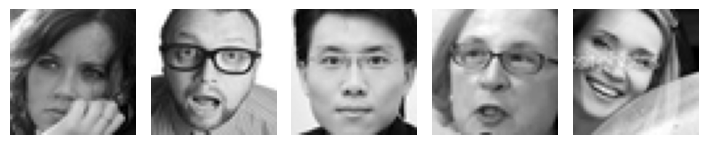

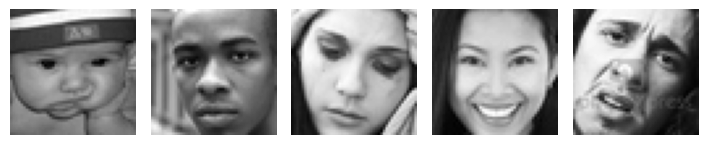

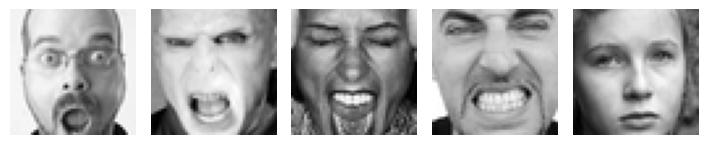

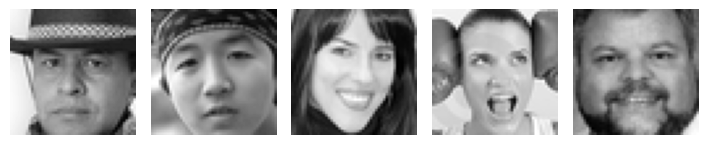

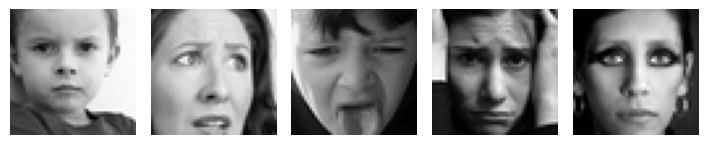

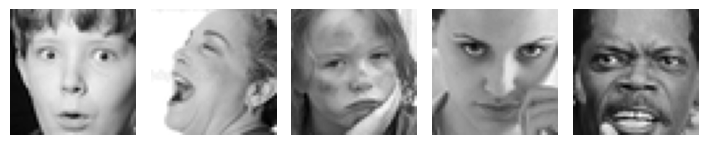

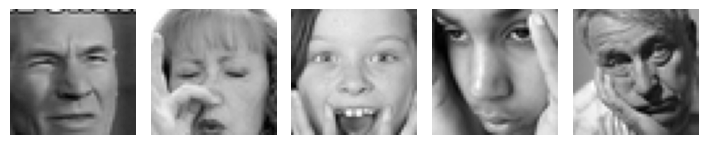

In [57]:
#plot images from each cluster to identify classes

# print(parameters['training_set'])
# print(model.labels_)

scaler_reverse = scaler.inverse_transform(parameters['training_set'])
#print(scaler_reverse)

pixel_values = scaler_reverse

cluster = model.labels_

print(np.unique(cluster))

list_of_tuples = list(zip(pixel_values, cluster))

plotting_df = pd.DataFrame(list_of_tuples, columns = ['Pixel Values', 'Cluster'])

#print(plotting_df)

grouped_df = plotting_df.groupby('Cluster')['Pixel Values'].apply(list).reset_index(name='Pixel Arrays')

print(grouped_df)

# Function to plot images
def plot_images(images):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(7, 7, i + 1)
        plt.imshow(np.array(img).reshape(48,48), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot 10 random images from each cluster
for _, row in grouped_df.iterrows():
    cluster_images = row['Pixel Arrays']
    random_indices = np.random.choice(len(cluster_images), size=min(5, len(cluster_images)), replace=False)
    random_images = [cluster_images[i] for i in random_indices]
    plot_images(random_images)










In [58]:
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score

#Trial of DBSCAN method, needs to be improved

# eps_range = range(6, 12)
# minpts_range = range(3, 8)

# scores = []
# comb = []

# for k in eps_range:
#     for j in minpts_range:
#         # Set the model and its parameters
#         model = DBSCAN(eps=k / 100, min_samples=j)
#         # Fit the model
#         clm = model.fit(training_set)

#         # Check if the number of unique labels is greater than 1
#         unique_labels = np.unique(clm.labels_)
#         if len(unique_labels) > 1:
#             # Calculate Silhouette Score and append to a list
#             scores.append(silhouette_score(training_set, clm.labels_, metric='euclidean'))
#             comb.append(str(k) + "|" + str(j))  # axis values for the graph
#         else:
#             print(f"Ignored combination: eps={k/100}, min_samples={j}, as it produced only one cluster.")


# print("scores: ", scores)
# print(max(scores))





**Model Evaluation**

**Conclusion text**